In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts/')
from utils import *
from processing import *
import pickle
from hyperopt import tpe, fmin, hp
from hyperopt.pyll.base import scope
from sklearn.decomposition import PCA
import shap
import torch
from torch import nn 
import torch.nn.functional as F
from skorch import NeuralNetClassifier

## Loading Data

In [2]:
# Original data
data = load_data("prediction_cam")
data

,PatientStayID,Class,Age,APACHEIVscore,APACHEIVaScore,Metabolic,UrgentAdmission,AdmissionCategory,Infection,NumBeds,...,min_bicarbonate_totalCO2_HCO3,max_bicarbonate_totalCO2_HCO3,count_bicarbonate_totalCO2_HCO3,diff_bicarbonate_totalCO2_HCO3,first_24hr_dialysis,first_24hr_urine,first_24hr_rbc,first_24hr_plasma,first_24hr_platelet_transf,first_24hr_surgical
0,242154,1,46.0,77.0,77.0,0,1.0,2.0,True,4.0,...,26.0,32.0,5.0,-2.0,0,2010.0,0,0,0,0
1,242290,0,75.0,77.0,77.0,0,1.0,2.0,True,4.0,...,20.0,23.0,2.0,3.0,0,1310.0,0,0,0,0
2,242474,0,52.0,64.0,64.0,1,1.0,4.0,False,4.0,...,25.0,25.0,1.0,NaN,0,1935.0,0,0,0,0
3,242505,1,90.0,78.0,78.0,0,1.0,2.0,True,4.0,...,19.0,19.0,2.0,0.0,0,2345.0,1,0,0,0
4,242714,0,78.0,-1.0,-1.0,0,1.0,4.0,True,4.0,...,28.0,28.0,1.0,NaN,0,1900.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18300,3352193,0,19.0,-1.0,-1.0,1,1.0,3.0,True,4.0,...,19.7,23.0,2.0,3.3,0,550.0,0,0,0,0
18301,3352331,0,75.0,48.0,48.0,0,1.0,4.0,False,2.0,...,NaN,NaN,NaN,NaN,0,2025.0,0,0,0,0
18302,3352964,0,85.0,75.0,75.0,0,1.0,2.0,False,2.0,...,36.5,38.0,2.0,-1.5,0,1625.0,0,0,0,0
18303,3353044,0,52.0,41.0,41.0,0,1.0,4.0,False,2.0,...,23.0,23.0,1.0,NaN,0,1840.0,0,0,0,0


In [3]:
# Validation Set
validation = pd.read_csv("../csv/early_24hr_data/early_24hr_validation/early_24hr_validation_data_set.csv")
validation.drop(columns=['HistLiverFail', 'HistMetastases', 'HistLymphoma', 'HistLeukemia', 'HistAIDS', 'Ethnicity'], inplace=True)

In [4]:
np.sum(validation["Class"] == 0)

4531

In [5]:
for col in validation.columns:
    print(col)
    print(missing_data(validation, col))

PatientStayID
(0, 5299)
Class
(0, 5299)
AdmitTime24
(0, 5299)
Gender
(0, 5299)
AdmitWeight
(54, 5299)
TeachingStatus
(0, 5299)
Age
(0, 5299)
UrgentAdmission
(0, 5299)
UnitAdmitTime
(0, 5299)
NumBeds
(0, 5299)
UnitType
(0, 5299)
APACHEIVscore
(0, 5299)
Infection
(0, 5299)
AdmissionCategory
(0, 5299)
HistAICD
(56, 5299)
HistAngina
(56, 5299)
HistAplasticAnemia
(56, 5299)
HistArrythmia
(56, 5299)
HistAsthma
(56, 5299)
HistCABG
(56, 5299)
HistCancer
(56, 5299)
HistChemotherapy
(56, 5299)
HistCHF
(56, 5299)
HistCirrhosis
(56, 5299)
HistClottingDisorder
(56, 5299)
HistCOPD
(56, 5299)
HistCushing
(56, 5299)
HistDementia
(56, 5299)
Histdiabetes
(56, 5299)
HistHeartTransp
(56, 5299)
HistHemolyticAnemia
(56, 5299)
HistHypercalcemia
(56, 5299)
HistHypercoagulableCondition
(56, 5299)
HistHypersplenism
(56, 5299)
HistHypertension
(56, 5299)
Histhyperthyroid
(56, 5299)
Histhypothyroid
(56, 5299)
HistImmuneSuppr
(56, 5299)
HistIntracranialMass
(56, 5299)
HistLiverTransp
(56, 5299)
HistLungTransp
(56,

In [6]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)

APACHEIVaScore
Metabolic
AdmitHeight
AdmitSource
UnitAdmitSource
24hrWorstMotorGCS
24hrWorstVerbalGCS
24hrWorstEyesGCS
24hrBestMotorGCS
24hrBestVerbalGCS
24hrBestEyesGCS
mean_bedside glucose
min_bedside glucose
max_bedside glucose
count_bedside glucose
diff_bedside glucose
mean_MPV
min_MPV
max_MPV
count_MPV
diff_MPV
mean_-polys
min_-polys
max_-polys
count_-polys
diff_-polys


In [7]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)

## Processing

In [8]:
features_to_use = validation.columns
#data = data.loc[:, features_to_use]

In [9]:
data = process_all(data)
for col in data.columns:
    if missing_data(data, col)[0] > 0.2*missing_data(data,col)[1]:
        data.drop(labels=[col], axis=1, inplace=True)

common_imputation= ["Gender", "Infection", "TeachingStatus", "UrgentAdmission", "First24hrComa", "ventilator"]
for col in data.columns:
    if col.startswith("comorbidity_") or col.startswith("Hist"):
        common_imputation.append(col)

one_hot_removal = []#["UnitAdmitSource_Missing"]
remove = ["APACHEIVaScore", "FirstDayHaloperidol", "FirstDayPrecedex", '24hrWorstMotorGCS','24hrWorstVerbalGCS','24hrWorstEyesGCS', '24hrBestMotorGCS', '24hrBestVerbalGCS', '24hrBestEyesGCS', "sofa_vasopressors", "UnitAdmitSource_Missing"]
exceptions = []

mean_imputation = data.columns
mean_imputation = mean_imputation.drop(common_imputation)
mean_imputation = mean_imputation.drop(one_hot_removal)
mean_imputation = mean_imputation.drop(remove)
mean_imputation = mean_imputation.drop(exceptions)
mean_imputation = mean_imputation.tolist()


for col in data.columns:
    if col.startswith("count_"):
        data[col] = data[col].fillna(0)
    if col.startswith("diff_"):
        data[col] = data[col].fillna(0)


from sklearn.impute import SimpleImputer
data.drop(remove, axis=1, inplace = True)
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(data[mean_imputation])
data[mean_imputation] = imp_mean.transform(data[mean_imputation])
imp_freq = SimpleImputer(strategy='most_frequent')
imp_freq.fit(data[common_imputation])
data[common_imputation] = imp_freq.transform(data[common_imputation])

# Manual common imputation of UnitAdmit
# data.loc[data["UnitAdmitSource_Missing"] == 1, ["UnitAdmitSource_EmergencyDep"]] == 1
#data[one_hot_removal] = data[one_hot_removal].replace(1, np.NaN)
data.dropna(inplace = True)
data

,PatientStayID,Class,Age,APACHEIVscore,Metabolic,UrgentAdmission,Infection,NumBeds,TeachingStatus,Gender,...,UnitAdmitTimeInt,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU
0,242154.0,1.0,46.0,77.000000,0.0,1.0,1.0,4.0,0.0,1.0,...,63000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,242290.0,0.0,75.0,77.000000,0.0,1.0,1.0,4.0,0.0,1.0,...,61200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,242474.0,0.0,52.0,64.000000,1.0,1.0,0.0,4.0,0.0,0.0,...,55260.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,242505.0,1.0,90.0,78.000000,0.0,1.0,1.0,4.0,0.0,1.0,...,600.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,242714.0,0.0,78.0,57.094888,0.0,1.0,1.0,4.0,0.0,0.0,...,66000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18300,3352193.0,0.0,19.0,57.094888,1.0,1.0,1.0,4.0,0.0,1.0,...,38700.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18301,3352331.0,0.0,75.0,48.000000,0.0,1.0,0.0,2.0,0.0,1.0,...,14100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18302,3352964.0,0.0,85.0,75.000000,0.0,1.0,0.0,2.0,0.0,1.0,...,4620.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18303,3353044.0,0.0,52.0,41.000000,0.0,1.0,0.0,2.0,0.0,0.0,...,55320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
validation = process_all(validation)

In [11]:
for col in validation.columns:
    print(col)
    print(missing_data(validation, col))

PatientStayID
(0, 5299)
Class
(0, 5299)
Gender
(0, 5299)
AdmitWeight
(54, 5299)
TeachingStatus
(0, 5299)
Age
(0, 5299)
UrgentAdmission
(0, 5299)
NumBeds
(0, 5299)
APACHEIVscore
(0, 5299)
Infection
(0, 5299)
HistAICD
(56, 5299)
HistAngina
(56, 5299)
HistAplasticAnemia
(56, 5299)
HistArrythmia
(56, 5299)
HistAsthma
(56, 5299)
HistCABG
(56, 5299)
HistCancer
(56, 5299)
HistChemotherapy
(56, 5299)
HistCHF
(56, 5299)
HistCirrhosis
(56, 5299)
HistClottingDisorder
(56, 5299)
HistCOPD
(56, 5299)
HistCushing
(56, 5299)
HistDementia
(56, 5299)
Histdiabetes
(56, 5299)
HistHeartTransp
(56, 5299)
HistHemolyticAnemia
(56, 5299)
HistHypercalcemia
(56, 5299)
HistHypercoagulableCondition
(56, 5299)
HistHypersplenism
(56, 5299)
HistHypertension
(56, 5299)
Histhyperthyroid
(56, 5299)
Histhypothyroid
(56, 5299)
HistImmuneSuppr
(56, 5299)
HistIntracranialMass
(56, 5299)
HistLiverTransp
(56, 5299)
HistLungTransp
(56, 5299)
HistMI
(56, 5299)
HistMyeloproliferativeDisease
(56, 5299)
HistNeurogenicBladd
(56, 52

In [12]:
# Mismatch in Features, features in original that aren't in validation
for col in data.columns:
    if col not in validation.columns:
        print(col)
        validation[col] = np.nan

Metabolic
AdmitHeight
UnitType_Neuro
UnitAdmitSource_DirectAdmit
UnitAdmitSource_EmergencyDep
UnitAdmitSource_Floor
UnitAdmitSource_ICU
UnitAdmitSource_OR
UnitAdmitSource_Other
UnitAdmitSource_OtherHospital
UnitAdmitSource_PACU
UnitAdmitSource_SDU


In [13]:
# Mismatch in Features, features in validation that aren't in original
for col in validation.columns:
    if col not in data.columns:
        print(col)
        validation.drop(columns=[col], inplace=True)

FirstDayHaloperidol
FirstDayPrecedex
sofa_vasopressors
mean_albumin
min_albumin
max_albumin
count_albumin
diff_albumin
mean_alkaline phos.
min_alkaline phos.
max_alkaline phos.
count_alkaline phos.
diff_alkaline phos.
mean_ALT (SGPT)
min_ALT (SGPT)
max_ALT (SGPT)
count_ALT (SGPT)
diff_ALT (SGPT)
mean_anion gap
min_anion gap
max_anion gap
count_anion gap
diff_anion gap
mean_AST (SGOT)
min_AST (SGOT)
max_AST (SGOT)
count_AST (SGOT)
diff_AST (SGOT)
diff_BUN
diff_calcium
diff_chloride
diff_creatinine
mean_FiO2
min_FiO2
max_FiO2
count_FiO2
diff_FiO2
diff_glucose
diff_Hct
diff_Hgb
mean_lactate
min_lactate
max_lactate
count_lactate
diff_lactate
mean_-lymphs
min_-lymphs
max_-lymphs
count_-lymphs
diff_-lymphs
mean_magnesium
min_magnesium
max_magnesium
count_magnesium
diff_magnesium
mean_MCH
min_MCH
max_MCH
count_MCH
diff_MCH
diff_MCHC
diff_MCV
mean_-monos
min_-monos
max_-monos
count_-monos
diff_-monos
mean_O2 Sat (%)
min_O2 Sat (%)
max_O2 Sat (%)
count_O2 Sat (%)
diff_O2 Sat (%)
mean_paCO2
min_

In [14]:
validation = validation[data.columns]

In [15]:
validation[mean_imputation] = imp_mean.transform(validation[mean_imputation])
validation[common_imputation] = imp_freq.transform(validation[common_imputation])

In [16]:
labels = data['Class']
data.drop(['Class'], axis=1, inplace=True)

In [17]:
validation_labels = validation['Class']
validation.drop(['Class'], axis=1, inplace=True)

In [18]:
with open("../pickle/early_24hr_data/mean_unpruned/lr_calibrated_dropped_feats.pkl", "rb") as f:
	dropped_feat = pickle.load(f)


data_pruned = data.drop(dropped_feat, axis=1, errors='ignore')
validation_pruned = validation.drop(dropped_feat, axis=1, errors='ignore')

In [19]:
data

,PatientStayID,Age,APACHEIVscore,Metabolic,UrgentAdmission,Infection,NumBeds,TeachingStatus,Gender,AdmitHeight,...,UnitAdmitTimeInt,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU
0,242154.0,46.0,77.000000,0.0,1.0,1.0,4.0,0.0,1.0,157.48,...,63000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,242290.0,75.0,77.000000,0.0,1.0,1.0,4.0,0.0,1.0,165.10,...,61200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,242474.0,52.0,64.000000,1.0,1.0,0.0,4.0,0.0,0.0,177.80,...,55260.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,242505.0,90.0,78.000000,0.0,1.0,1.0,4.0,0.0,1.0,165.10,...,600.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,242714.0,78.0,57.094888,0.0,1.0,1.0,4.0,0.0,0.0,182.90,...,66000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18300,3352193.0,19.0,57.094888,1.0,1.0,1.0,4.0,0.0,1.0,157.50,...,38700.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18301,3352331.0,75.0,48.000000,0.0,1.0,0.0,2.0,0.0,1.0,167.60,...,14100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18302,3352964.0,85.0,75.000000,0.0,1.0,0.0,2.0,0.0,1.0,162.00,...,4620.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18303,3353044.0,52.0,41.000000,0.0,1.0,0.0,2.0,0.0,0.0,175.00,...,55320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
validation

,PatientStayID,Age,APACHEIVscore,Metabolic,UrgentAdmission,Infection,NumBeds,TeachingStatus,Gender,AdmitHeight,...,UnitAdmitTimeInt,UnitAdmitSource_DirectAdmit,UnitAdmitSource_EmergencyDep,UnitAdmitSource_Floor,UnitAdmitSource_ICU,UnitAdmitSource_OR,UnitAdmitSource_Other,UnitAdmitSource_OtherHospital,UnitAdmitSource_PACU,UnitAdmitSource_SDU
0,200001.0,61.065753,85.0,0.152964,1.0,0.0,4.0,1.0,1.0,168.845871,...,68772.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
1,200028.0,64.865753,85.0,0.152964,0.0,0.0,4.0,1.0,0.0,168.845871,...,62030.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
2,200035.0,30.673973,52.0,0.152964,1.0,0.0,4.0,1.0,0.0,168.845871,...,50202.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
3,200040.0,72.038356,29.0,0.152964,1.0,0.0,4.0,1.0,0.0,168.845871,...,57701.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
4,200049.0,64.438356,75.0,0.152964,1.0,0.0,4.0,1.0,0.0,168.845871,...,32204.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,299933.0,64.328767,37.0,0.152964,0.0,0.0,4.0,1.0,0.0,168.845871,...,52837.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
5295,299949.0,22.934247,47.0,0.152964,1.0,0.0,4.0,1.0,0.0,168.845871,...,20565.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
5296,299950.0,75.934247,58.0,0.152964,1.0,0.0,4.0,1.0,1.0,168.845871,...,48329.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953
5297,299957.0,60.745205,57.0,0.152964,1.0,0.0,4.0,1.0,1.0,168.845871,...,38477.0,0.058017,0.493308,0.177984,0.020978,0.08637,0.001038,0.03693,0.071073,0.051953


## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**{'ccp_alpha': 0.0001338317167915429, 'max_depth': 30, 'max_features': 0.09593503840416163, 'max_samples': 0.8138031161081002, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 750})
clf.fit(data.iloc[:, 1:], labels)

RandomForestClassifier(ccp_alpha=0.0001338317167915429, max_depth=30,
                       max_features=0.09593503840416163,
                       max_samples=0.8138031161081002, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=750)

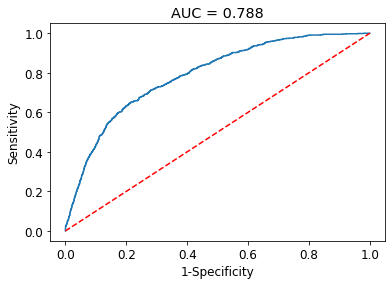

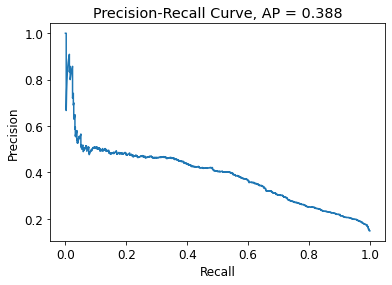

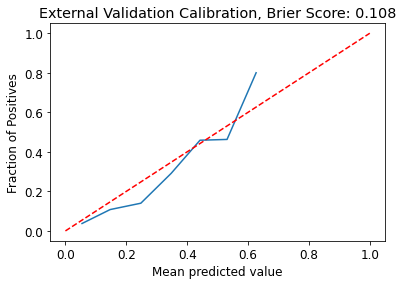

In [55]:
predictions = clf.predict_proba(validation.iloc[:, 1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
#plt.savefig("../figures/early_24hr_data/validation/roc.png")
plt.show()

temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
#plt.savefig("../figures/early_24hr_data/validation/precision_recall.png")
plt.show()

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
#plt.savefig("../figures/early_24hr_data/validation/calibration.png")
plt.show()


Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelEncoder from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator _SigmoidCalibration from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator CalibratedClassifierCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


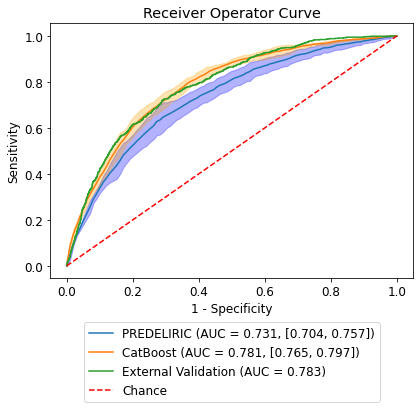

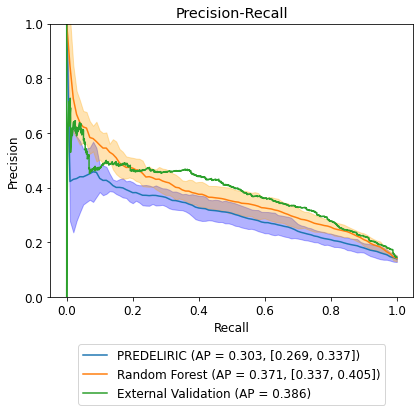

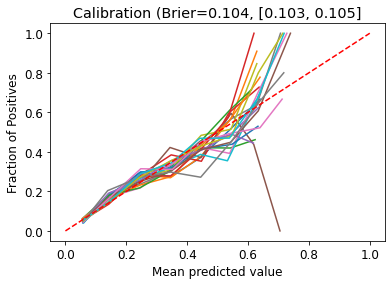

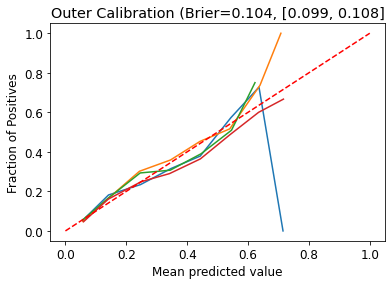

In [52]:
import pickle
with open("../pickle/early_24hr_data/mean_unpruned/rf", "rb") as f:
    catboost_result = pickle.load(f)

result_dict = catboost_result
name = "/early_24hr_data/validation/rf"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})


with open("../pickle/early_24hr_data/mean_unpruned/predeliric", "rb") as f:
    predeliric = pickle.load(f)

# ROC's
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])

predeliric_outer_mid_tpr, predeliric_outer_up_tpr, predeliric_outer_low_tpr = compute_confidence(predeliric["otpr"])
predeliric_outer_mid_auc, predeliric_outer_up_auc, predeliric_outer_low_auc = compute_confidence(predeliric["oauc"])


plt.figure(figsize=(6,6))
plt.plot(base_fpr, predeliric_outer_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, predeliric_outer_low_tpr, predeliric_outer_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("PREDELIRIC (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_auc, predeliric_outer_low_auc, predeliric_outer_up_auc),
    "CatBoost (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()


base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])

predeliric_outer_mid_precision, predeliric_outer_up_precision, predeliric_outer_low_precision = compute_confidence(predeliric["op"])
predeliric_outer_mid_ap, predeliric_outer_up_ap, predeliric_outer_low_ap = compute_confidence(predeliric["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, predeliric_outer_mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision)
plt.fill_between(base_recall, predeliric_outer_low_precision, predeliric_outer_up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("PREDELIRIC (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_ap, predeliric_outer_low_ap, predeliric_outer_up_ap),
    "Random Forest (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap)),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

## CatBoost Models

In [27]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data.iloc[:, 1:], labels)

ing: 13.5s
2629:	learn: 0.2149198	total: 1m 35s	remaining: 13.4s
2630:	learn: 0.2148765	total: 1m 35s	remaining: 13.4s
2631:	learn: 0.2148198	total: 1m 35s	remaining: 13.4s
2632:	learn: 0.2148018	total: 1m 35s	remaining: 13.3s
2633:	learn: 0.2147646	total: 1m 35s	remaining: 13.3s
2634:	learn: 0.2147124	total: 1m 35s	remaining: 13.3s
2635:	learn: 0.2146958	total: 1m 35s	remaining: 13.2s
2636:	learn: 0.2146746	total: 1m 35s	remaining: 13.2s
2637:	learn: 0.2146370	total: 1m 35s	remaining: 13.2s
2638:	learn: 0.2146006	total: 1m 35s	remaining: 13.1s
2639:	learn: 0.2145708	total: 1m 35s	remaining: 13.1s
2640:	learn: 0.2145301	total: 1m 36s	remaining: 13.1s
2641:	learn: 0.2144920	total: 1m 36s	remaining: 13s
2642:	learn: 0.2144723	total: 1m 36s	remaining: 13s
2643:	learn: 0.2144382	total: 1m 36s	remaining: 12.9s
2644:	learn: 0.2143944	total: 1m 36s	remaining: 12.9s
2645:	learn: 0.2143608	total: 1m 36s	remaining: 12.9s
2646:	learn: 0.2143531	total: 1m 36s	remaining: 12.8s
2647:	learn: 0.214300

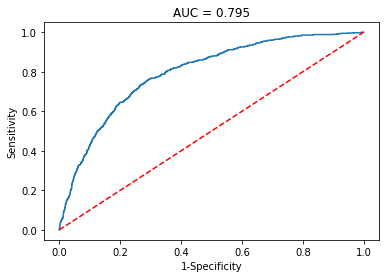

In [28]:
predictions = clf.predict_proba(validation.iloc[:,1:])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/early_24hr_data/validation/roc.png")
plt.show()


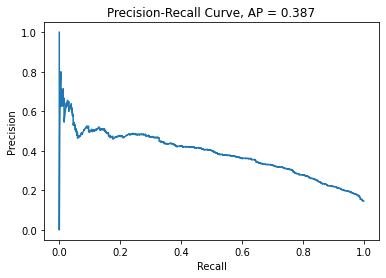

In [29]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/early_24hr_data/validation/precision_recall.png")
plt.show()

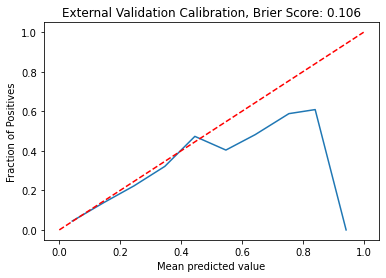

In [31]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/early_24hr_data/validation/calibration.png")
plt.show()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


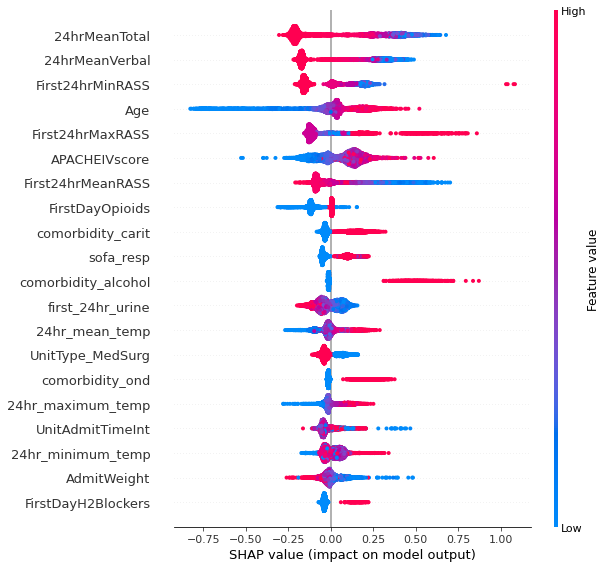

In [32]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(validation.iloc[:, 1:])
shap.summary_plot(shap_values, validation.iloc[:, 1:], show=False)
plt.savefig("../figures/early_24hr_data/validation/shapeley.png", bbox_inches="tight")

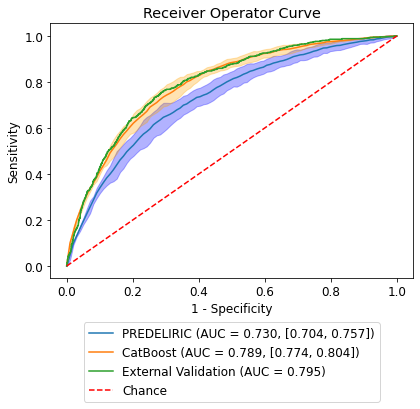

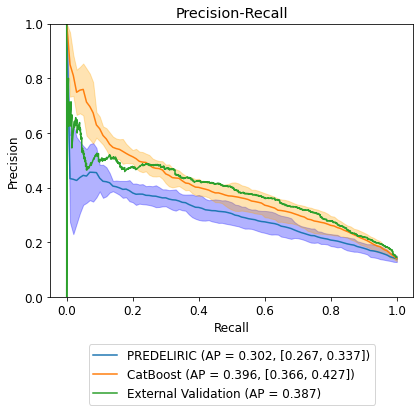

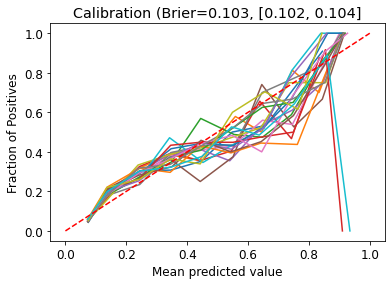

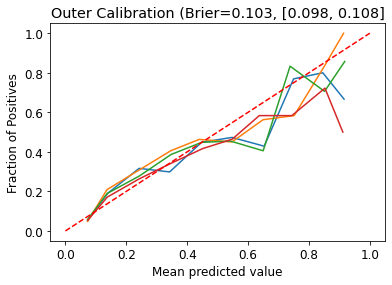

In [33]:
import pickle
with open("../pickle/early_24hr_data/mean_unpruned/catboost", "rb") as f:
    catboost_result = pickle.load(f)

result_dict = catboost_result
name = "/early_24hr_data/validation/catboost"

base_fpr = np.linspace(0, 1, 100)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})


with open("../pickle/early_24hr_data/mean_unpruned/predeliric", "rb") as f:
    predeliric = pickle.load(f)

# ROC's
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])

predeliric_outer_mid_tpr, predeliric_outer_up_tpr, predeliric_outer_low_tpr = compute_confidence(predeliric["otpr"])
predeliric_outer_mid_auc, predeliric_outer_up_auc, predeliric_outer_low_auc = compute_confidence(predeliric["oauc"])


plt.figure(figsize=(6,6))
plt.plot(base_fpr, predeliric_outer_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, predeliric_outer_low_tpr, predeliric_outer_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.legend(("PREDELIRIC (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_auc, predeliric_outer_low_auc, predeliric_outer_up_auc),
    "CatBoost (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()


base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])

predeliric_outer_mid_precision, predeliric_outer_up_precision, predeliric_outer_low_precision = compute_confidence(predeliric["op"])
predeliric_outer_mid_ap, predeliric_outer_up_ap, predeliric_outer_low_ap = compute_confidence(predeliric["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, predeliric_outer_mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision)
plt.fill_between(base_recall, predeliric_outer_low_precision, predeliric_outer_up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.ylim([0,1])
plt.legend(("PREDELIRIC (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_ap, predeliric_outer_low_ap, predeliric_outer_up_ap),
    "CatBoost (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap)),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()



mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure()
for i in range(len(result_dict["oprobtrue"])):
    plt.plot(result_dict["oprobpred"][i], result_dict["oprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration_outer.png".format(name), dpi = 'figure')
plt.show()

In [21]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(**{"n_estimators": 3000})
clf.fit(data_pruned.iloc[:, 1:], labels)

Learning rate set to 0.013018
0:	learn: 0.6823457	total: 188ms	remaining: 9m 24s
1:	learn: 0.6721012	total: 206ms	remaining: 5m 8s
2:	learn: 0.6614598	total: 223ms	remaining: 3m 42s
3:	learn: 0.6520468	total: 240ms	remaining: 2m 59s
4:	learn: 0.6425610	total: 260ms	remaining: 2m 35s
5:	learn: 0.6334683	total: 275ms	remaining: 2m 17s
6:	learn: 0.6249005	total: 295ms	remaining: 2m 6s
7:	learn: 0.6170426	total: 311ms	remaining: 1m 56s
8:	learn: 0.6086777	total: 328ms	remaining: 1m 49s
9:	learn: 0.6008244	total: 343ms	remaining: 1m 42s
10:	learn: 0.5929688	total: 360ms	remaining: 1m 37s
11:	learn: 0.5858321	total: 375ms	remaining: 1m 33s
12:	learn: 0.5789997	total: 392ms	remaining: 1m 30s
13:	learn: 0.5719748	total: 408ms	remaining: 1m 27s
14:	learn: 0.5654778	total: 427ms	remaining: 1m 24s
15:	learn: 0.5595652	total: 445ms	remaining: 1m 23s
16:	learn: 0.5534562	total: 464ms	remaining: 1m 21s
17:	learn: 0.5470806	total: 483ms	remaining: 1m 19s
18:	learn: 0.5409677	total: 500ms	remaining: 1

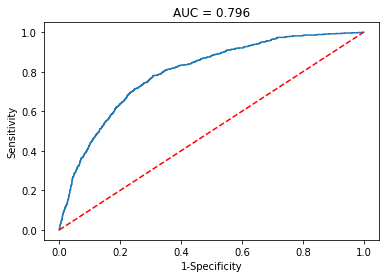

In [22]:
predictions = clf.predict_proba(validation_pruned.iloc[:, ])

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(validation_labels), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(validation_labels), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC = {:.3f}".format(auc))
plt.savefig("../figures/early_24hr_data/validation/roc_pruned.png")
plt.show()


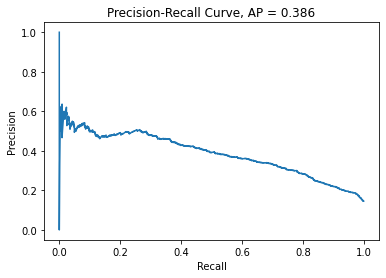

In [23]:
temp_precision, temp_recall, _ = metrics.precision_recall_curve(validation_labels, predictions[:, 1])
ap = metrics.average_precision_score(validation_labels, predictions[:, 1])
plt.figure()
plt.plot(temp_recall, temp_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve, AP = {:.3f}".format(ap))
plt.savefig("../figures/early_24hr_data/validation/precision_recall_pruned.png")
plt.show()

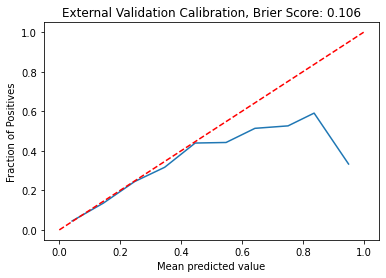

In [24]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

fraction_of_positives, mean_predicted_value = calibration_curve(validation_labels, predictions[:, 1], n_bins=10)
brier = brier_score_loss(validation_labels, predictions[:, 1])


plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("External Validation Calibration, Brier Score: {:.3f}".format(brier))
plt.savefig("../figures/early_24hr_data/validation/calibration_pruned.png")
plt.show()


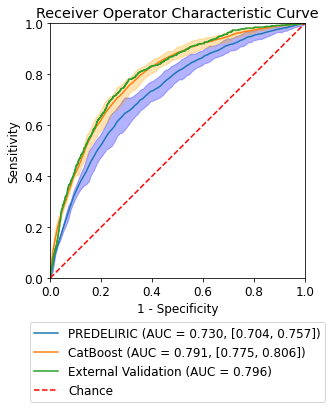

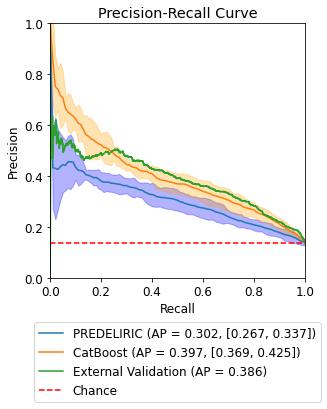

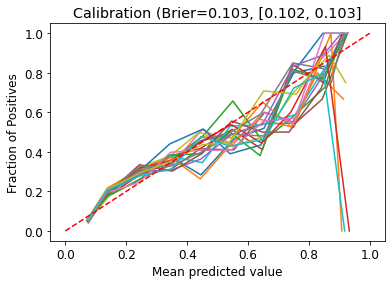

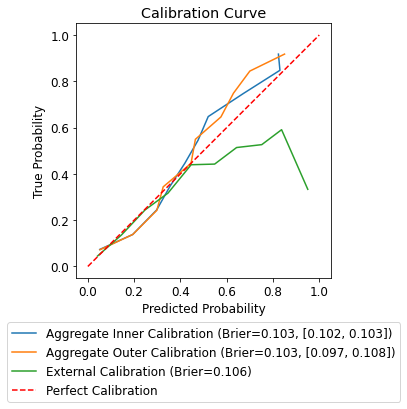

In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})


import pickle
with open("../pickle/early_24hr_data/mean_pruned/catboost", "rb") as f:
    catboost_result = pickle.load(f)

result_dict = catboost_result
name = "/early_24hr_data/validation/catboost_pruned"

base_fpr = np.linspace(0, 1, 100)

with open("../pickle/early_24hr_data/mean_unpruned/pr_baseline", "rb") as f:
    pr_baseline = pickle.load(f)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})


with open("../pickle/early_24hr_data/mean_unpruned/predeliric", "rb") as f:
    predeliric = pickle.load(f)

# ROC's
outer_mid_tpr, outer_up_tpr, outer_low_tpr = compute_confidence(result_dict["otpr"])
outer_mid_auc, outer_up_auc, outer_low_auc = compute_confidence(result_dict["oauc"])

predeliric_outer_mid_tpr, predeliric_outer_up_tpr, predeliric_outer_low_tpr = compute_confidence(predeliric["otpr"])
predeliric_outer_mid_auc, predeliric_outer_up_auc, predeliric_outer_low_auc = compute_confidence(predeliric["oauc"])


plt.figure(figsize=(6,6))
plt.plot(base_fpr, predeliric_outer_mid_tpr, base_fpr, outer_mid_tpr, fpr, tpr, [0, 1], [0, 1], 'r--')
plt.fill_between(base_fpr, predeliric_outer_low_tpr, predeliric_outer_up_tpr, color='blue', alpha=0.3)
plt.fill_between(base_fpr, outer_low_tpr, outer_up_tpr, color='orange', alpha=0.3)
plt.xlabel("1 - Specificity") 
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Characteristic Curve")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(("PREDELIRIC (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_auc, predeliric_outer_low_auc, predeliric_outer_up_auc),
    "CatBoost (AUC = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_auc, outer_low_auc, outer_up_auc),
    "External Validation (AUC = {0:.3f})".format(auc),
    'Chance'), loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_ROC.png".format(name), dpi = 'figure')
plt.show()


base_recall = np.linspace(1,0,101)

outer_mid_precision, outer_up_precision, outer_low_precision = compute_confidence(result_dict["op"])
outer_mid_ap, outer_up_ap, outer_low_ap = compute_confidence(result_dict["oap"])

predeliric_outer_mid_precision, predeliric_outer_up_precision, predeliric_outer_low_precision = compute_confidence(predeliric["op"])
predeliric_outer_mid_ap, predeliric_outer_up_ap, predeliric_outer_low_ap = compute_confidence(predeliric["oap"])


plt.figure(figsize=(6,6))
plt.plot(base_recall, predeliric_outer_mid_precision, base_recall, outer_mid_precision, temp_recall, temp_precision, [0, 1], [pr_baseline, pr_baseline], 'r--')
plt.fill_between(base_recall, predeliric_outer_low_precision, predeliric_outer_up_precision, color='blue', alpha=0.3)
plt.fill_between(base_recall, outer_low_precision, outer_up_precision, color='orange', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(("PREDELIRIC (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(predeliric_outer_mid_ap, predeliric_outer_low_ap, predeliric_outer_up_ap),
    "CatBoost (AP = {0:.3f}, [{1:.3f}, {2:.3f}])".format(outer_mid_ap, outer_low_ap, outer_up_ap),
    "External Validation (AP = {0:.3f})".format(ap),
    "Chance"),
    loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_PR.png".format(name), dpi = 'figure')
plt.show()


mid_brier, up_brier, low_brier = compute_confidence(np.asarray(result_dict["ibrier"]))

plt.figure()
for i in range(len(result_dict["iprobtrue"])):
    plt.plot(result_dict["iprobpred"][i], result_dict["iprobtrue"][i])
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of Positives")
plt.title("Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}]".format(mid_brier, low_brier, up_brier))
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

o_mid_brier, o_up_brier, o_low_brier = compute_confidence(np.asarray(result_dict["obrier"]))

plt.figure(figsize=(6,6))
ipred = result_dict["ifullpred"]
ilabels = result_dict["ilabels"]

pred = []
lab = []
for i in range(len(ipred)):
    for j in range(len(ipred[i])):
        pred.append(ipred[i][j])
        lab.append(np.asarray(ilabels[i])[j])

prob_true, prob_pred = calibration_curve(
			lab, pred, n_bins=10
)

plt.plot(prob_true, prob_pred)


opred = result_dict["ofullpred"]
olabels = result_dict["olabels"]

pred = []
lab = []
for i in range(len(opred)):
    for j in range(len(opred[i])):
        pred.append(opred[i][j])
        lab.append(olabels[i][j])

prob_true, prob_pred = calibration_curve(
			lab, pred, n_bins=10
)

plt.plot(prob_true, prob_pred)
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(["Aggregate Inner Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}])".format(mid_brier, low_brier, up_brier),
"Aggregate Outer Calibration (Brier={0:.3f}, [{1:.3f}, {2:.3f}])".format(o_mid_brier, o_low_brier, o_up_brier),
"External Calibration (Brier={0:.3f})".format(brier),
 "Perfect Calibration"],
 loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../figures/{}_Calibration.png".format(name), dpi = 'figure')
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


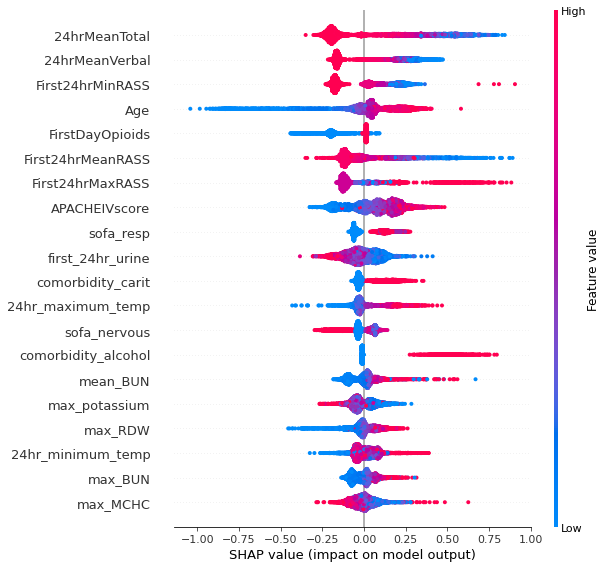

In [25]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(validation_pruned.iloc[:, 1:])
shap.summary_plot(shap_values, validation_pruned.iloc[:, 1:], show=False)
plt.savefig("../figures/early_24hr_data/validation/catboost_pruned_validation_shapeley.png", bbox_inches="tight")

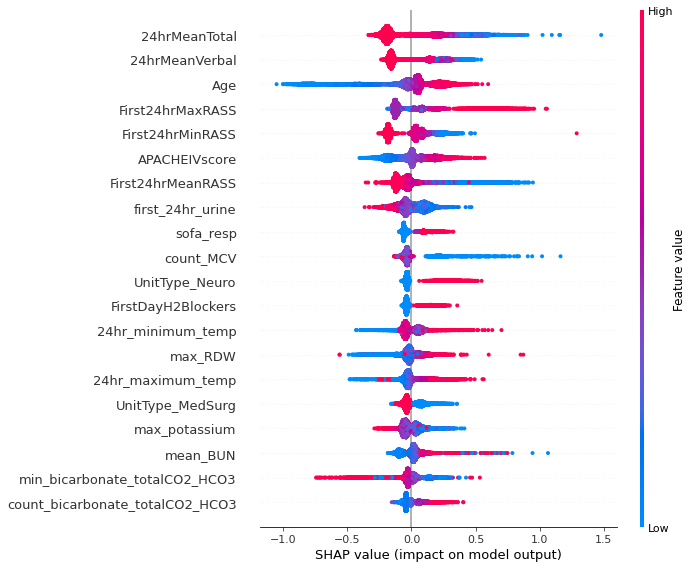

In [26]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(data_pruned.iloc[:, 1:])
shap.summary_plot(shap_values, data_pruned.iloc[:, 1:], show=False)
plt.savefig("../figures/early_24hr_data/validation/catboost_pruned_training_shapeley.png", bbox_inches="tight")